# Home assignment 2

### Deadline: 8th January, 2025 at 23:59 CET

### Name & Student No.:
- Abdel Kader, Schehat & 10064822
- Tarbouch, Johny & 10033994
- Asfari, Mustafa & 10075209

# Steps

CIFAR-10 dataset, it has 10 classes 'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'

Each images in dataset with 3 RGB channel color images of size 32x32.

Steps:
1. Load dataset
2. Define the Variational Autoencoder (VAE), or conVAE.
3. Training the VAE
4. Visualizing Results

**2 VAE [40 points]**
1. Load the dataset and display some examples. Use a subset, if you run into memory issues.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.datasets import CIFAR10

import torch.optim as optim

Files already downloaded and verified
Files already downloaded and verified


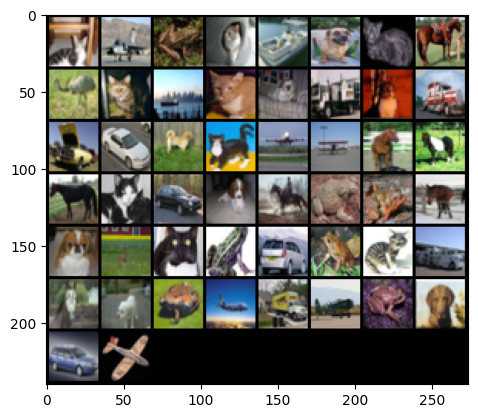

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

x_train = train_dataset.data / 255.0  # Normalize to [0, 1]
x_test = test_dataset.data / 255.0

# Convert to tensors
x_train_tensor = torch.tensor(x_train).permute(0, 3, 1, 2).float()  # Convert to (N, C, H, W)
x_test_tensor = torch.tensor(x_test).permute(0, 3, 1, 2).float()

train_loader = DataLoader(TensorDataset(x_train_tensor, x_train_tensor), batch_size=50, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, x_test_tensor), batch_size=50, shuffle=False)

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

2. Implement an encoder and decoder and combine them to form a VAE (see also Exercise Week 6).
- As the images are a different size, you cannot copy the architecture directly. Alsonote that CIFAR10 has three color channels, while MNIST only has one!
- You may use any number (> 1) of latent dimensions.
- Briefly explain your design choices, including the chosen number of latent dimensions.

**Answer**
Brief explanation of design choices:
- Encoder consists of convolutional layers instead of fully connected layers to extract features from the input images. At the end map to latent space with fully connect layers
- Latent dimension is a parameter. We will check later in the training with different values what is good latent dimension number    
- The decoder mirrors the encoder with one fully connected layer and transposed convolutional layers to reconstruct the images from the latent space
- The reparameterization trick is used to sample from the latent space during training

In [3]:
class VAE(nn.Module):
    def __init__(self, z_dim=128):
        super(VAE, self).__init__()
        self.z_dim = z_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (B, 256, 4, 4)
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, z_dim)

        # Decoder
        self.decoder_fc = nn.Linear(z_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, 32, 32)
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the feature map
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise, as we need the same size
        return mu + eps*std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 4, 4)  # Reshape to start the decoder
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

3. Explain the loss function you use.

**Answer** \
The loss function for the VAE consists of two components:

1. **Reconstruction Loss**: measures how well the decoder is able to reconstruct the input data from the latent space. We use MSE

2. **KL Divergence Loss**: measures how much the latent space distribution deviates from the standard normal distribution. Acts as a regularizer, encouraging the latent space to follow a normal distribution. This allows a smooth latent space to sample from and interpolation

The total loss is the sum of these two components:

$$
\text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence Loss}
$$

Mathematically, the KL divergence for a Gaussian distribution is given by:

$$
\text{D}_{KL}(q(z|x) \| p(z)) = -\frac{1}{2} \sum_{i=1}^{L} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)
$$

L is the number of latent dimensions. And we want to encourage a normal distribution

$$
D_{KL}\left[N(\mu, \sigma) \parallel N(0, 1)\right]
$$

We tried different loss functions for the reconstruction loss, BCE and MSE. We had better results with MSE and additionally by normalizing the data between 0 and 1

In [4]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence loss
    # D_KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

4. Train the VAE for a few epochs and compare some input and reconstruction images after
each epoch.

**Training**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae_z_8 = VAE(z_dim=8).to(device)
vae_z_16 = VAE(z_dim=16).to(device)
vae_z_32 = VAE(z_dim=32).to(device)
vae_z_64 = VAE(z_dim=64).to(device)
vae_z_128 = VAE(z_dim=128).to(device)
vae_z_256 = VAE(z_dim=256).to(device)

optimizer_z_8 = optim.Adam(vae_z_8.parameters(), lr=1e-3)
optimizer_z_16 = optim.Adam(vae_z_16.parameters(), lr=1e-3)
optimizer_z_32 = optim.Adam(vae_z_32.parameters(), lr=1e-3)
optimizer_z_64 = optim.Adam(vae_z_64.parameters(), lr=1e-3)
optimizer_z_128 = optim.Adam(vae_z_128.parameters(), lr=1e-3)
optimizer_z_256 = optim.Adam(vae_z_256.parameters(), lr=1e-3)

In [6]:
def train(epoch, vae, optimizer):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Train Epoch: {epoch} Average Loss: {train_loss / len(train_loader.dataset)}")

In [7]:
epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_8, optimizer_z_8)

Train Epoch: 1 Average Loss: 103.751643125
Train Epoch: 2 Average Loss: 88.80562784667968
Train Epoch: 3 Average Loss: 88.00968102539062
Train Epoch: 4 Average Loss: 87.49829194335938
Train Epoch: 5 Average Loss: 87.03820604980469
Train Epoch: 6 Average Loss: 86.8249976171875
Train Epoch: 7 Average Loss: 86.619960546875
Train Epoch: 8 Average Loss: 86.370541171875
Train Epoch: 9 Average Loss: 86.18099091308594
Train Epoch: 10 Average Loss: 86.040990625
Train Epoch: 11 Average Loss: 85.8441164453125
Train Epoch: 12 Average Loss: 85.70425153320312
Train Epoch: 13 Average Loss: 85.5873894140625
Train Epoch: 14 Average Loss: 85.44791918457031
Train Epoch: 15 Average Loss: 85.430814375
Train Epoch: 16 Average Loss: 85.30857690429687
Train Epoch: 17 Average Loss: 85.17851446289062
Train Epoch: 18 Average Loss: 85.11676573730469
Train Epoch: 19 Average Loss: 85.03488362304688
Train Epoch: 20 Average Loss: 84.98658083007813


In [8]:
epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_16, optimizer_z_16)

Train Epoch: 1 Average Loss: 96.6149104296875
Train Epoch: 2 Average Loss: 80.51974373535157
Train Epoch: 3 Average Loss: 79.51441720214844
Train Epoch: 4 Average Loss: 78.78626932128907
Train Epoch: 5 Average Loss: 78.42432798828125
Train Epoch: 6 Average Loss: 78.18590151367188
Train Epoch: 7 Average Loss: 77.93815479003906
Train Epoch: 8 Average Loss: 77.7599959765625
Train Epoch: 9 Average Loss: 77.50687240722657
Train Epoch: 10 Average Loss: 77.36172293945313
Train Epoch: 11 Average Loss: 77.21157851074219
Train Epoch: 12 Average Loss: 77.10661722167968
Train Epoch: 13 Average Loss: 76.98725165527344
Train Epoch: 14 Average Loss: 76.85422125488282
Train Epoch: 15 Average Loss: 76.7975511767578
Train Epoch: 16 Average Loss: 76.69618689941406
Train Epoch: 17 Average Loss: 76.63773634277344
Train Epoch: 18 Average Loss: 76.55446641113281
Train Epoch: 19 Average Loss: 76.5435416015625
Train Epoch: 20 Average Loss: 76.465091484375


In [9]:
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_32, optimizer_z_32)

Train Epoch: 1 Average Loss: 98.95017434082031
Train Epoch: 2 Average Loss: 79.29312883789062
Train Epoch: 3 Average Loss: 77.57126766113281
Train Epoch: 4 Average Loss: 76.73890428710938
Train Epoch: 5 Average Loss: 76.19124083007813
Train Epoch: 6 Average Loss: 75.7928728515625
Train Epoch: 7 Average Loss: 75.4783710595703
Train Epoch: 8 Average Loss: 75.26323328125
Train Epoch: 9 Average Loss: 75.08720852539062
Train Epoch: 10 Average Loss: 74.96554769042969
Train Epoch: 11 Average Loss: 74.82523015625
Train Epoch: 12 Average Loss: 74.70846235839844
Train Epoch: 13 Average Loss: 74.59682625
Train Epoch: 14 Average Loss: 74.4703503466797
Train Epoch: 15 Average Loss: 74.41500516113281
Train Epoch: 16 Average Loss: 74.29371381835938
Train Epoch: 17 Average Loss: 74.22143940917968
Train Epoch: 18 Average Loss: 74.18638626953125
Train Epoch: 19 Average Loss: 74.13291382324219
Train Epoch: 20 Average Loss: 74.022585703125


In [10]:
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_64, optimizer_z_64)

Train Epoch: 1 Average Loss: 104.03815905273437
Train Epoch: 2 Average Loss: 80.5372650390625
Train Epoch: 3 Average Loss: 78.48512610351563
Train Epoch: 4 Average Loss: 77.55462077636719
Train Epoch: 5 Average Loss: 76.8274479296875
Train Epoch: 6 Average Loss: 76.40293014648438
Train Epoch: 7 Average Loss: 75.94823255371094
Train Epoch: 8 Average Loss: 75.70781321777343
Train Epoch: 9 Average Loss: 75.46380368164063
Train Epoch: 10 Average Loss: 75.36616443359375
Train Epoch: 11 Average Loss: 75.21270529785156
Train Epoch: 12 Average Loss: 75.07193450195312
Train Epoch: 13 Average Loss: 74.92039537109375
Train Epoch: 14 Average Loss: 74.7955912109375
Train Epoch: 15 Average Loss: 74.70932442382812
Train Epoch: 16 Average Loss: 74.67192770507812
Train Epoch: 17 Average Loss: 74.53101298339844
Train Epoch: 18 Average Loss: 74.48882910644531
Train Epoch: 19 Average Loss: 74.41030144042969
Train Epoch: 20 Average Loss: 74.34893970214844


In [11]:
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_128, optimizer_z_128)

Train Epoch: 1 Average Loss: 106.48628590332031
Train Epoch: 2 Average Loss: 81.47407100585937
Train Epoch: 3 Average Loss: 79.1128803125
Train Epoch: 4 Average Loss: 77.94506390625
Train Epoch: 5 Average Loss: 77.29245528808593
Train Epoch: 6 Average Loss: 76.79351145507812
Train Epoch: 7 Average Loss: 76.57395781738282
Train Epoch: 8 Average Loss: 76.31637505371094
Train Epoch: 9 Average Loss: 76.06246946777344
Train Epoch: 10 Average Loss: 75.93334958007813
Train Epoch: 11 Average Loss: 75.78332018554687
Train Epoch: 12 Average Loss: 75.671442578125
Train Epoch: 13 Average Loss: 75.50990287597656
Train Epoch: 14 Average Loss: 75.41859671875
Train Epoch: 15 Average Loss: 75.25473595703124
Train Epoch: 16 Average Loss: 75.19092905761718
Train Epoch: 17 Average Loss: 75.0402456640625
Train Epoch: 18 Average Loss: 74.99626591308594
Train Epoch: 19 Average Loss: 74.90683092773438
Train Epoch: 20 Average Loss: 74.83546330078126


In [12]:
for epoch in range(1, epochs + 1):
    train(epoch, vae_z_256, optimizer_z_256)

Train Epoch: 1 Average Loss: 115.23304086914062
Train Epoch: 2 Average Loss: 84.15856838378906
Train Epoch: 3 Average Loss: 80.34202852050781
Train Epoch: 4 Average Loss: 78.9382947998047
Train Epoch: 5 Average Loss: 78.09822103515624
Train Epoch: 6 Average Loss: 77.65033451171875
Train Epoch: 7 Average Loss: 77.30517600097656
Train Epoch: 8 Average Loss: 77.01994733398438
Train Epoch: 9 Average Loss: 76.79612983398438
Train Epoch: 10 Average Loss: 76.64416510253906
Train Epoch: 11 Average Loss: 76.41506313476563
Train Epoch: 12 Average Loss: 76.29058828125
Train Epoch: 13 Average Loss: 76.18147557128906
Train Epoch: 14 Average Loss: 76.07927172363281
Train Epoch: 15 Average Loss: 75.98913155761718
Train Epoch: 16 Average Loss: 75.90567593261719
Train Epoch: 17 Average Loss: 75.77515436523437
Train Epoch: 18 Average Loss: 75.69705690429687
Train Epoch: 19 Average Loss: 75.5994990576172
Train Epoch: 20 Average Loss: 75.47918129882812


**Conclusion**
- During the training, the latent dimension number with the best result was z = 32

**Visualizing Results**

In [13]:
import matplotlib.pyplot as plt

In [14]:
def display_images(original, decoded, count=10):
    n = count
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # show original input image
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i].permute(1, 2, 0).cpu().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display decoded image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i].permute(1, 2, 0).cpu().detach().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

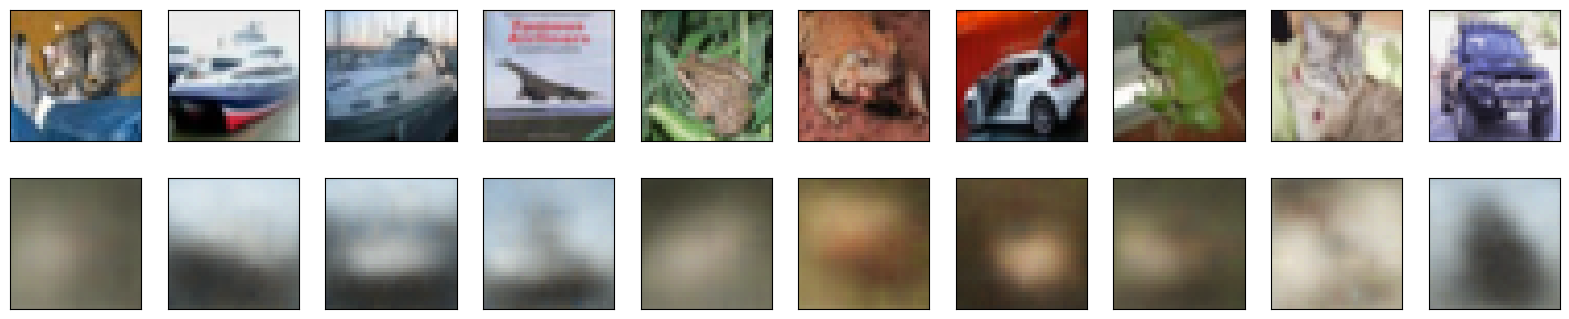

In [15]:
# Test the VAE
vae_z_8.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_8(sample)
    display_images(sample, recon_sample)

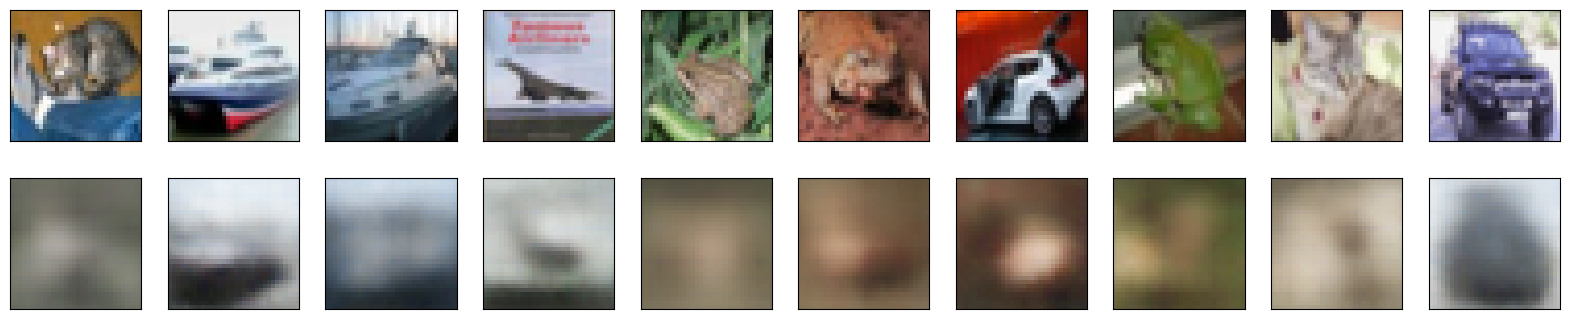

In [16]:
vae_z_16.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_16(sample)
    display_images(sample, recon_sample)

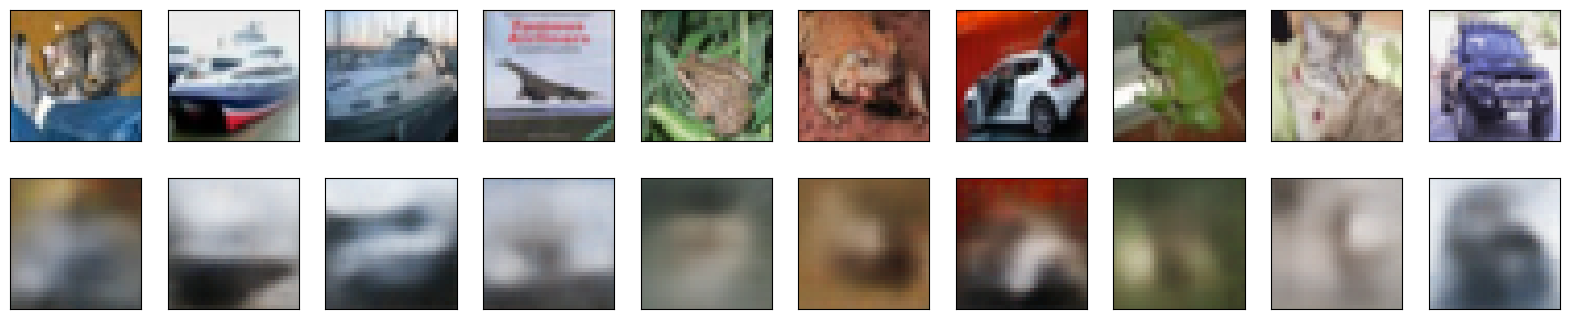

In [17]:
vae_z_32.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_32(sample)
    display_images(sample, recon_sample)

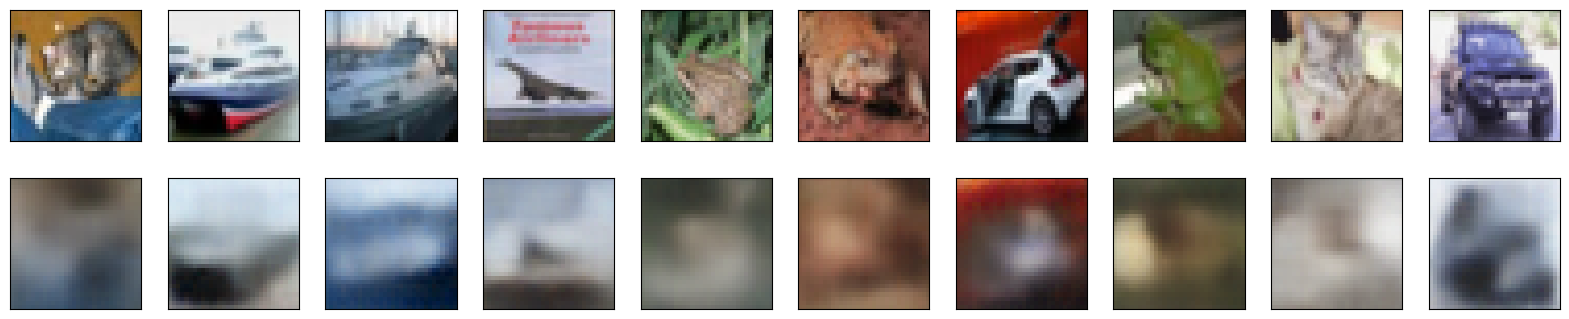

In [18]:
vae_z_64.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_64(sample)
    display_images(sample, recon_sample)

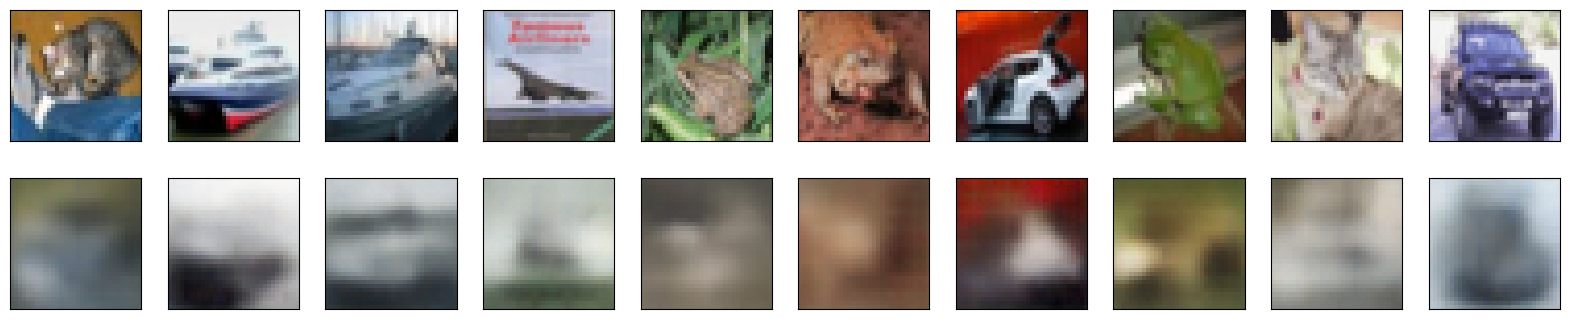

In [19]:
vae_z_128.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_128(sample)
    display_images(sample, recon_sample)

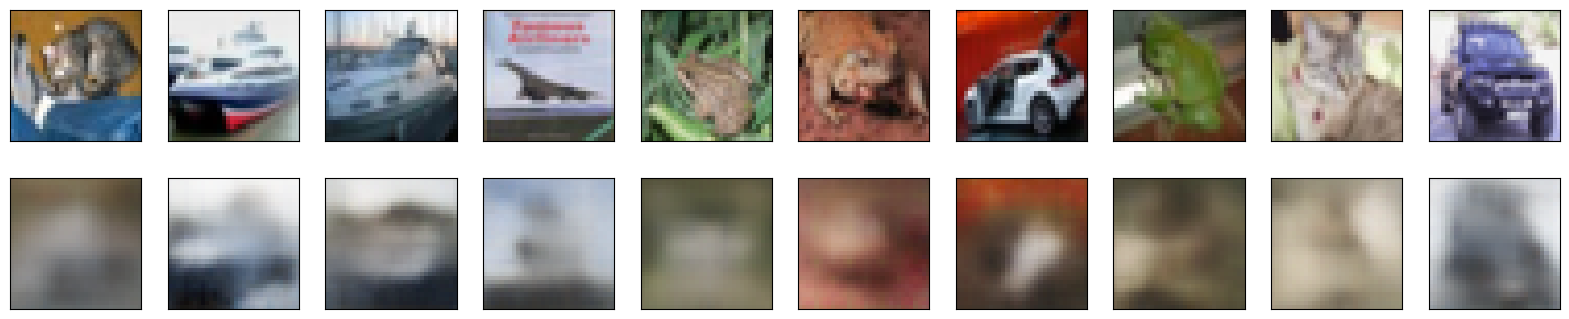

In [20]:
vae_z_256.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0].to(device)
    recon_sample, _, _ = vae_z_256(sample)
    display_images(sample, recon_sample)